# Protocol Selection of FedLeak (CenterCrop Generator), Lung & Colon Cancer (LC25000)

Here is the protocol selection to decide in which way should FedLeak be transferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=False`.
- *Way to report*: best PSNRs in $5$ times recovery.

Codes are aligned with `sanity_check_resize_LC25000.ipynb`, with two modifications utilized:
- ⭕ Force generating with $224\times224\times3$.
- ⭕ Abort comparing with `upsampling` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, utils, argparse, os
from criteria import *
from utils import upscale, get_resnet18
from resize_generator import FedLeak
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:1")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
loader_iter = iter(trainloader)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

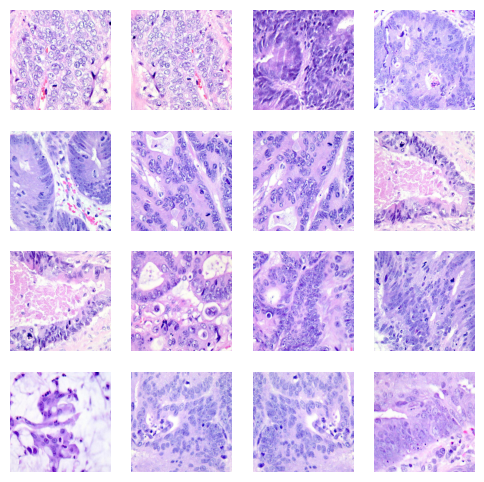

| It: 1 | Loss: -42.9600 | Time:   6.13s |


| It: 1001 | Loss: -58.8055 | Time: 777.75s |


| It: 2001 | Loss: -60.3226 | Time: 780.20s |


| It: 3001 | Loss: -60.8149 | Time: 778.96s |


| It: 4001 | Loss: -61.0808 | Time: 779.02s |


| It: 5001 | Loss: -61.2608 | Time: 779.27s |


| It: 6001 | Loss: -61.3970 | Time: 777.96s |


| It: 7001 | Loss: -61.4848 | Time: 777.85s |


| It: 8001 | Loss: -61.5448 | Time: 777.92s |


| It: 9001 | Loss: -61.5755 | Time: 778.09s |


| It: 1 | Loss: -40.5672 | Time:   0.81s |


| It: 1001 | Loss: -58.9090 | Time: 777.64s |


| It: 2001 | Loss: -60.1908 | Time: 778.53s |


| It: 3001 | Loss: -60.6623 | Time: 777.60s |


| It: 4001 | Loss: -60.9434 | Time: 776.88s |


| It: 5001 | Loss: -61.1765 | Time: 780.82s |


| It: 6001 | Loss: -61.3093 | Time: 780.29s |


| It: 7001 | Loss: -61.4241 | Time: 780.22s |


| It: 8001 | Loss: -61.5018 | Time: 780.54s |


| It: 9001 | Loss: -61.5386 | Time: 779.68s |


| It: 1 | Loss: -41.1450 | Time:   0.83s |


| It: 1001 | Loss: -59.3950 | Time: 779.82s |


| It: 2001 | Loss: -60.5666 | Time: 779.94s |


| It: 3001 | Loss: -60.9733 | Time: 779.76s |


| It: 4001 | Loss: -61.1975 | Time: 779.47s |


| It: 5001 | Loss: -61.3329 | Time: 779.21s |


| It: 6001 | Loss: -61.4448 | Time: 779.94s |


| It: 7001 | Loss: -61.5259 | Time: 780.09s |


| It: 8001 | Loss: -61.5793 | Time: 780.51s |


| It: 9001 | Loss: -61.6056 | Time: 780.47s |


| It: 1 | Loss: -41.3148 | Time:   0.84s |


| It: 1001 | Loss: -58.8102 | Time: 779.67s |


| It: 2001 | Loss: -60.0646 | Time: 780.01s |


| It: 3001 | Loss: -60.6797 | Time: 780.98s |


| It: 4001 | Loss: -61.0174 | Time: 780.34s |


| It: 5001 | Loss: -61.2167 | Time: 781.25s |


| It: 6001 | Loss: -61.3554 | Time: 780.44s |


| It: 7001 | Loss: -61.4490 | Time: 781.80s |


| It: 8001 | Loss: -61.5155 | Time: 780.28s |


| It: 9001 | Loss: -61.5484 | Time: 780.68s |


| It: 1 | Loss: -42.6867 | Time:   0.81s |


| It: 1001 | Loss: -58.8630 | Time: 780.07s |


| It: 2001 | Loss: -59.9693 | Time: 778.32s |


| It: 3001 | Loss: -60.5676 | Time: 779.75s |


| It: 4001 | Loss: -60.9251 | Time: 779.76s |


| It: 5001 | Loss: -61.1285 | Time: 781.00s |


| It: 6001 | Loss: -61.2717 | Time: 781.75s |


| It: 7001 | Loss: -61.3856 | Time: 779.83s |


| It: 8001 | Loss: -61.4577 | Time: 779.46s |


| It: 9001 | Loss: -61.4936 | Time: 780.32s |


BEST PSNR: 14.1177
MEDIAN PSNR: 13.4144
ALL PSNR: [14.0379, 11.7982, 14.1177, 14.0878, 14.0878]


<Figure size 400x300 with 0 Axes>

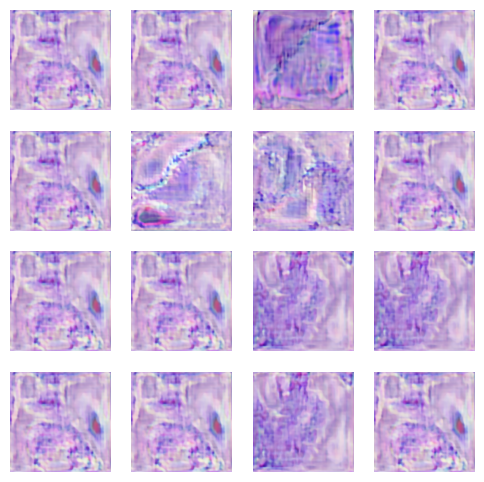

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

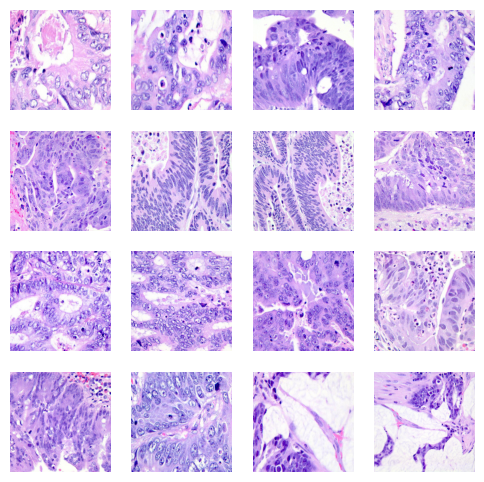

| It: 1 | Loss: -41.5446 | Time:   0.82s |


| It: 1001 | Loss: -57.8943 | Time: 780.04s |


| It: 2001 | Loss: -59.6166 | Time: 779.32s |


| It: 3001 | Loss: -60.4165 | Time: 780.26s |


| It: 4001 | Loss: -60.7864 | Time: 780.82s |


| It: 5001 | Loss: -61.0462 | Time: 778.67s |


| It: 6001 | Loss: -61.2294 | Time: 779.56s |


| It: 7001 | Loss: -61.3618 | Time: 781.15s |


| It: 8001 | Loss: -61.4453 | Time: 779.21s |


| It: 9001 | Loss: -61.4862 | Time: 780.24s |


| It: 1 | Loss: -38.7399 | Time:   0.76s |


| It: 1001 | Loss: -58.1649 | Time: 781.17s |


| It: 2001 | Loss: -59.5882 | Time: 781.02s |


| It: 3001 | Loss: -60.3532 | Time: 779.24s |


| It: 4001 | Loss: -60.7783 | Time: 780.65s |


| It: 5001 | Loss: -60.9958 | Time: 781.12s |


| It: 6001 | Loss: -61.2295 | Time: 779.45s |


| It: 7001 | Loss: -61.3510 | Time: 780.25s |


| It: 8001 | Loss: -61.4426 | Time: 779.75s |


| It: 9001 | Loss: -61.4847 | Time: 780.83s |


| It: 1 | Loss: -41.3151 | Time:   0.81s |


| It: 1001 | Loss: -58.2118 | Time: 780.54s |


| It: 2001 | Loss: -59.6535 | Time: 780.41s |


| It: 3001 | Loss: -60.4127 | Time: 779.81s |


| It: 4001 | Loss: -60.7872 | Time: 780.33s |


| It: 5001 | Loss: -61.0388 | Time: 781.60s |


| It: 6001 | Loss: -61.2196 | Time: 780.63s |


| It: 7001 | Loss: -61.3466 | Time: 781.09s |


| It: 8001 | Loss: -61.4281 | Time: 779.80s |


| It: 9001 | Loss: -61.4703 | Time: 780.18s |


| It: 1 | Loss: -40.7969 | Time:   0.79s |


| It: 1001 | Loss: -58.1179 | Time: 779.88s |


| It: 2001 | Loss: -59.5930 | Time: 779.32s |


| It: 3001 | Loss: -60.2116 | Time: 779.47s |


| It: 4001 | Loss: -60.6876 | Time: 779.72s |


| It: 5001 | Loss: -60.9585 | Time: 780.07s |


| It: 6001 | Loss: -61.1630 | Time: 779.68s |


| It: 7001 | Loss: -61.3113 | Time: 779.44s |


| It: 8001 | Loss: -61.4071 | Time: 781.16s |


| It: 9001 | Loss: -61.4530 | Time: 781.07s |


| It: 1 | Loss: -39.8479 | Time:   0.82s |


| It: 1001 | Loss: -57.9739 | Time: 779.86s |


| It: 2001 | Loss: -59.4691 | Time: 780.20s |


| It: 3001 | Loss: -60.2013 | Time: 777.90s |


| It: 4001 | Loss: -60.6249 | Time: 780.83s |


| It: 5001 | Loss: -60.8998 | Time: 778.97s |


| It: 6001 | Loss: -61.1147 | Time: 779.53s |


| It: 7001 | Loss: -61.2564 | Time: 780.33s |


| It: 8001 | Loss: -61.3448 | Time: 779.99s |


| It: 9001 | Loss: -61.3913 | Time: 780.78s |


BEST PSNR: 13.3357
MEDIAN PSNR: 12.5504
ALL PSNR: [13.3357, 11.3713, 12.8209, 12.3768, 12.3768]


<Figure size 400x300 with 0 Axes>

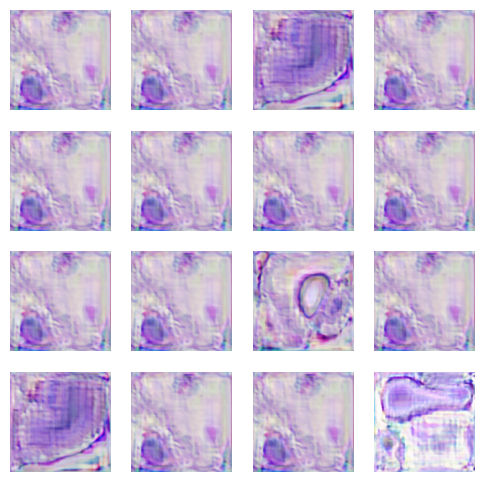

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

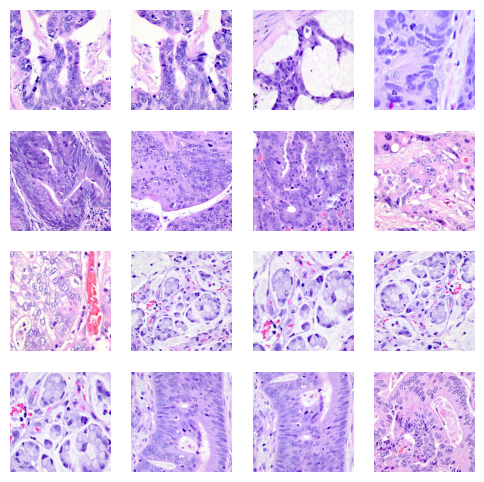

| It: 1 | Loss: -42.3979 | Time:   0.73s |


| It: 1001 | Loss: -59.2761 | Time: 778.28s |


| It: 2001 | Loss: -60.3725 | Time: 778.70s |


| It: 3001 | Loss: -60.8492 | Time: 777.44s |


| It: 4001 | Loss: -61.1124 | Time: 780.14s |


| It: 5001 | Loss: -61.2791 | Time: 779.78s |


| It: 6001 | Loss: -61.4010 | Time: 779.13s |


| It: 7001 | Loss: -61.4911 | Time: 780.36s |


| It: 8001 | Loss: -61.5468 | Time: 780.30s |


| It: 9001 | Loss: -61.5765 | Time: 780.40s |


| It: 1 | Loss: -39.8589 | Time:   0.82s |


| It: 1001 | Loss: -58.9858 | Time: 780.52s |


| It: 2001 | Loss: -60.2039 | Time: 778.89s |


| It: 3001 | Loss: -60.7765 | Time: 779.61s |


| It: 4001 | Loss: -61.0824 | Time: 779.97s |


| It: 5001 | Loss: -61.2674 | Time: 780.16s |


| It: 6001 | Loss: -61.3831 | Time: 778.46s |


| It: 7001 | Loss: -61.4800 | Time: 779.79s |


| It: 8001 | Loss: -61.5384 | Time: 780.48s |


| It: 9001 | Loss: -61.5703 | Time: 779.09s |


| It: 1 | Loss: -43.6179 | Time:   0.82s |


| It: 1001 | Loss: -58.8637 | Time: 780.16s |


| It: 2001 | Loss: -60.1194 | Time: 779.43s |


| It: 3001 | Loss: -60.6397 | Time: 779.02s |


| It: 4001 | Loss: -60.9497 | Time: 779.97s |


| It: 5001 | Loss: -61.1459 | Time: 779.85s |


| It: 6001 | Loss: -61.2969 | Time: 780.95s |


| It: 7001 | Loss: -61.4007 | Time: 780.80s |


| It: 8001 | Loss: -61.4697 | Time: 779.46s |


| It: 9001 | Loss: -61.5024 | Time: 780.35s |


| It: 1 | Loss: -40.8509 | Time:   0.82s |


| It: 1001 | Loss: -58.7925 | Time: 781.06s |


| It: 2001 | Loss: -59.8955 | Time: 780.11s |


| It: 3001 | Loss: -60.5699 | Time: 780.73s |


| It: 4001 | Loss: -60.8849 | Time: 780.06s |


| It: 5001 | Loss: -61.1010 | Time: 779.27s |


| It: 6001 | Loss: -61.2614 | Time: 779.14s |


| It: 7001 | Loss: -61.3746 | Time: 780.65s |


| It: 8001 | Loss: -61.4474 | Time: 780.36s |


| It: 9001 | Loss: -61.4830 | Time: 779.54s |


| It: 1 | Loss: -38.7047 | Time:   0.83s |


| It: 1001 | Loss: -59.1523 | Time: 779.15s |


| It: 2001 | Loss: -60.4308 | Time: 779.57s |


| It: 3001 | Loss: -60.8716 | Time: 779.39s |


| It: 4001 | Loss: -61.1134 | Time: 780.40s |


| It: 5001 | Loss: -61.2987 | Time: 781.25s |


| It: 6001 | Loss: -61.4181 | Time: 779.80s |


| It: 7001 | Loss: -61.5077 | Time: 781.18s |


| It: 8001 | Loss: -61.5642 | Time: 779.37s |


| It: 9001 | Loss: -61.5909 | Time: 779.48s |


BEST PSNR: 13.5016
MEDIAN PSNR: 12.3335
ALL PSNR: [12.7348, 11.6148, 11.5004, 12.3158, 12.3158]


<Figure size 400x300 with 0 Axes>

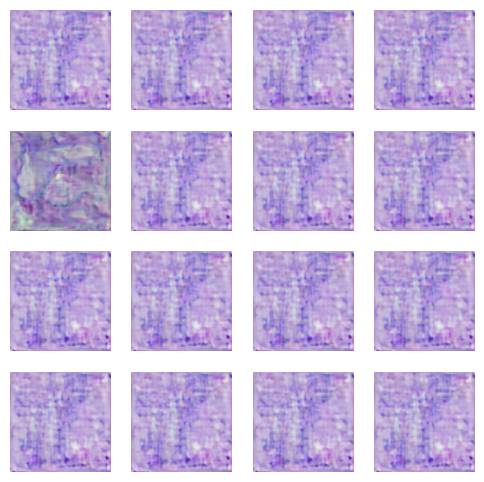

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

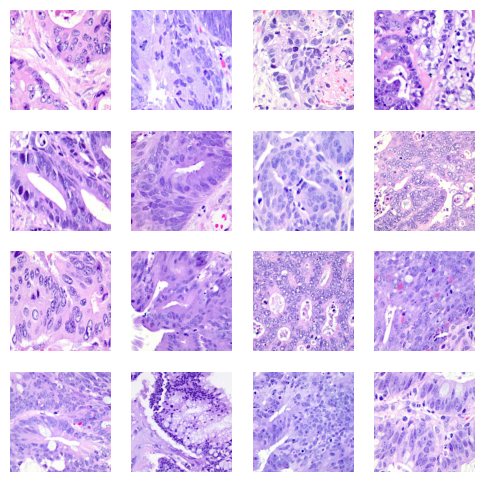

| It: 1 | Loss: -39.2049 | Time:   0.75s |


| It: 1001 | Loss: -58.0062 | Time: 781.03s |


| It: 2001 | Loss: -59.3119 | Time: 779.01s |


| It: 3001 | Loss: -60.0402 | Time: 778.54s |


| It: 4001 | Loss: -60.5205 | Time: 780.59s |


| It: 5001 | Loss: -60.8592 | Time: 778.07s |


| It: 6001 | Loss: -61.0657 | Time: 779.38s |


| It: 7001 | Loss: -61.2306 | Time: 780.14s |


| It: 8001 | Loss: -61.3305 | Time: 779.51s |


| It: 9001 | Loss: -61.3789 | Time: 778.51s |


| It: 1 | Loss: -41.6341 | Time:   0.81s |


| It: 1001 | Loss: -58.3124 | Time: 778.71s |


| It: 2001 | Loss: -59.8665 | Time: 780.15s |


| It: 3001 | Loss: -60.4924 | Time: 780.22s |


| It: 4001 | Loss: -60.8568 | Time: 777.58s |


| It: 5001 | Loss: -61.0964 | Time: 779.83s |


| It: 6001 | Loss: -61.2555 | Time: 780.11s |


| It: 7001 | Loss: -61.3676 | Time: 778.38s |


| It: 8001 | Loss: -61.4536 | Time: 779.13s |


| It: 9001 | Loss: -61.4908 | Time: 780.88s |


| It: 1 | Loss: -39.0168 | Time:   0.83s |


| It: 1001 | Loss: -58.3359 | Time: 779.83s |


| It: 2001 | Loss: -60.0253 | Time: 779.06s |


| It: 3001 | Loss: -60.6990 | Time: 780.48s |


| It: 4001 | Loss: -61.0254 | Time: 778.62s |


| It: 5001 | Loss: -61.2316 | Time: 777.59s |


| It: 6001 | Loss: -61.3691 | Time: 780.88s |


| It: 7001 | Loss: -61.4700 | Time: 779.10s |


| It: 8001 | Loss: -61.5339 | Time: 779.89s |


| It: 9001 | Loss: -61.5677 | Time: 780.16s |


| It: 1 | Loss: -41.6564 | Time:   0.75s |


| It: 1001 | Loss: -58.4854 | Time: 778.39s |


| It: 2001 | Loss: -59.5902 | Time: 778.89s |


| It: 3001 | Loss: -60.2038 | Time: 780.27s |


| It: 4001 | Loss: -60.6399 | Time: 780.71s |


| It: 5001 | Loss: -60.9141 | Time: 778.52s |


| It: 6001 | Loss: -61.1270 | Time: 778.74s |


| It: 7001 | Loss: -61.2723 | Time: 778.67s |


| It: 8001 | Loss: -61.3671 | Time: 779.43s |


| It: 9001 | Loss: -61.4160 | Time: 781.06s |


| It: 1 | Loss: -42.6236 | Time:   0.75s |


| It: 1001 | Loss: -57.8647 | Time: 779.62s |


| It: 2001 | Loss: -59.7657 | Time: 781.01s |


| It: 3001 | Loss: -60.4487 | Time: 781.42s |


| It: 4001 | Loss: -60.7882 | Time: 779.96s |


| It: 5001 | Loss: -61.0285 | Time: 780.53s |


| It: 6001 | Loss: -61.2089 | Time: 779.11s |


| It: 7001 | Loss: -61.3217 | Time: 778.75s |


| It: 8001 | Loss: -61.4181 | Time: 780.37s |


| It: 9001 | Loss: -61.4597 | Time: 780.14s |


BEST PSNR: 13.8846
MEDIAN PSNR: 13.1394
ALL PSNR: [13.8846, 13.7515, 12.9673, 11.8145, 11.8145]


<Figure size 400x300 with 0 Axes>

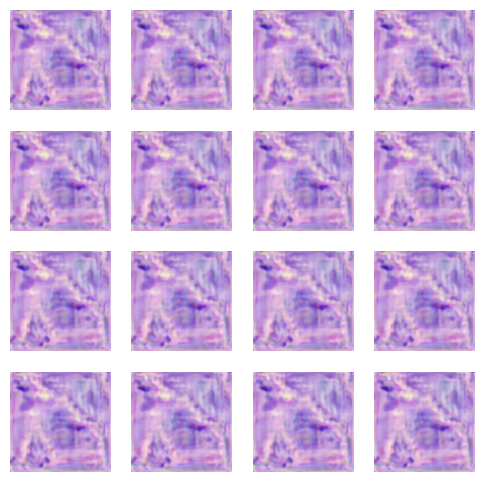

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

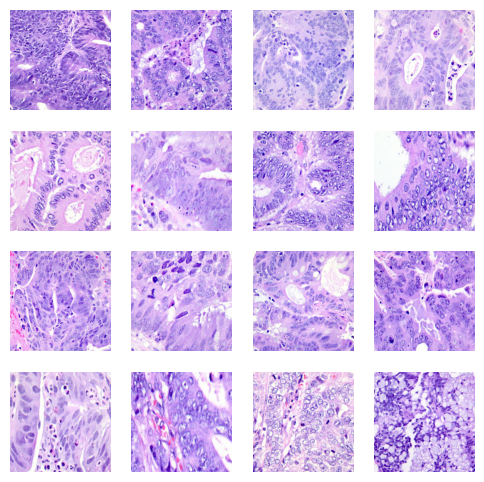

| It: 1 | Loss: -40.9218 | Time:   0.73s |


| It: 1001 | Loss: -58.6575 | Time: 780.82s |


| It: 2001 | Loss: -59.8129 | Time: 779.89s |


| It: 3001 | Loss: -60.3556 | Time: 781.11s |


| It: 4001 | Loss: -60.7265 | Time: 780.10s |


| It: 5001 | Loss: -60.9576 | Time: 780.28s |


| It: 6001 | Loss: -61.1642 | Time: 780.48s |


| It: 7001 | Loss: -61.2941 | Time: 780.92s |


| It: 8001 | Loss: -61.3836 | Time: 781.12s |


| It: 9001 | Loss: -61.4289 | Time: 779.59s |


| It: 1 | Loss: -39.0687 | Time:   0.82s |


| It: 1001 | Loss: -58.2820 | Time: 780.24s |


| It: 2001 | Loss: -59.7160 | Time: 781.23s |


| It: 3001 | Loss: -60.3820 | Time: 780.92s |


| It: 4001 | Loss: -60.7614 | Time: 778.93s |


| It: 5001 | Loss: -61.0002 | Time: 780.52s |


| It: 6001 | Loss: -61.1733 | Time: 781.17s |


| It: 7001 | Loss: -61.2952 | Time: 780.84s |


| It: 8001 | Loss: -61.3811 | Time: 779.70s |


| It: 9001 | Loss: -61.4235 | Time: 780.66s |


| It: 1 | Loss: -43.1646 | Time:   0.81s |


| It: 1001 | Loss: -57.6741 | Time: 781.19s |


| It: 2001 | Loss: -59.0438 | Time: 781.10s |


| It: 3001 | Loss: -59.6964 | Time: 780.81s |


| It: 4001 | Loss: -60.2671 | Time: 780.87s |


| It: 5001 | Loss: -60.5708 | Time: 780.73s |


| It: 6001 | Loss: -60.8450 | Time: 779.96s |


| It: 7001 | Loss: -61.0221 | Time: 781.78s |


| It: 8001 | Loss: -61.1516 | Time: 779.83s |


| It: 9001 | Loss: -61.2121 | Time: 779.17s |


| It: 1 | Loss: -40.4862 | Time:   0.83s |


| It: 1001 | Loss: -58.2659 | Time: 779.03s |


| It: 2001 | Loss: -59.6843 | Time: 780.97s |


| It: 3001 | Loss: -60.2905 | Time: 777.71s |


| It: 4001 | Loss: -60.6318 | Time: 778.38s |


| It: 5001 | Loss: -60.9311 | Time: 781.07s |


| It: 6001 | Loss: -61.0886 | Time: 778.35s |


| It: 7001 | Loss: -61.2420 | Time: 779.42s |


| It: 8001 | Loss: -61.3305 | Time: 781.85s |


| It: 9001 | Loss: -61.3789 | Time: 780.17s |


| It: 1 | Loss: -39.7403 | Time:   0.74s |


| It: 1001 | Loss: -57.5257 | Time: 780.17s |


| It: 2001 | Loss: -59.0393 | Time: 778.89s |


| It: 3001 | Loss: -59.9716 | Time: 780.72s |


| It: 4001 | Loss: -60.5053 | Time: 779.11s |


| It: 5001 | Loss: -60.7483 | Time: 778.60s |


| It: 6001 | Loss: -60.9944 | Time: 779.55s |


| It: 7001 | Loss: -61.1531 | Time: 778.55s |


| It: 8001 | Loss: -61.2480 | Time: 778.71s |


| It: 9001 | Loss: -61.3009 | Time: 781.06s |


BEST PSNR: 14.1706
MEDIAN PSNR: 13.4004
ALL PSNR: [12.1420, 12.7613, 13.9018, 14.0265, 14.0265]


<Figure size 400x300 with 0 Axes>

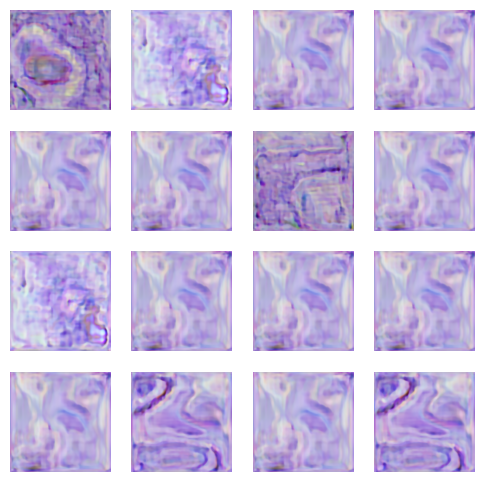

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)